In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import tqdm
import pandas as pd
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det, solve, cond

import matplotlib.pyplot as plt
import matplotlib

1.21.5
1.7.3


In [12]:
def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    #print("normalized_t: ", normalized_t)
    arg = (2*np.pi/P) * normalized_t
    #print("arg: ", arg)
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, factor2, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma (DEPRECATED): RV measurement uncertainties associated with each observation; np.array of length N [cm/s]; replaced by factor2
    - factor2: inverse covariance matrix; np.array of shape (N, N) [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    fim = np.zeros((len(theta),len(theta)))
    for i in range(len(theta)):
        for j in range(len(theta)):
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed

            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter

            fim[i][j] = factor1 @ factor2 @ factor3 # matrix math magic; thanks to Arvind Gupta for the wisdom
    
    return fim

In [50]:
### priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days

test_theta = [test_K, test_P, test_T0]

### free parameters from Langellier et al 2020 for correlated noise
# let's hold these constant for now, but maybe we should sample from the given uncertainties later?
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
Prot = 28.1 # solar rotation period; days
sigma_qp_s = 1.43e-3 # correlated noise amplitude
sigma_wn_s = 0.178e-3 # white noise amplitude
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]

def cov_matrix(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_s: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_s: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_s, sigma_wn_s = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = np.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (np.sin(np.pi * (t[i] - t[j])/Prot))**2
            arg = -term1 - term2
            k[i][j] = np.exp(arg)
    
    K = sigma_qp_s**2 * k + sigma_wn_s**2 * np.diag(np.ones(len(t)))
    
    return K

def make_t(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(start, end, n_obs, endpoint=False)
    #t = np.arange(start, end, cadence) + np.random.normal(0, 1./24)

    # add jitter ~ N(0, 1 hr) to timestamps
    t += np.random.normal(0, 1./24)

    return t

def strategy(start, n_obs, cadence, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
        sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        
        fim = calculate_fim(t, sigma, theta)
        #print("FIM: ", fim)
        #print("det: ", det(fim))
        inv_fim = inv(fim)
        #print("inv: ", inv_fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        #print("sigma_K, using inv: ", sigma_k)
        #sigma_ks.append(sigma_k)
        sigma_k_stable = np.sqrt(1/fim[0][0])
        #print("sigma_K, not using inv: ", sigma_k_stable)

        # np.linalg.solve is more stable than np.linalg.inv, apparently
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM
        
        fim = calculate_fim(t, sigma, theta)
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        sigma_k_stable = np.sqrt(1/fim[0][0])
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim

print(strategy(start=2352, n_obs=100, cadence=1, theta=test_theta, sigma_val=30)) # default to 2300
print(strategy(start=2352, n_obs=100, cadence=1, theta=test_theta)) # default to 2300

(4.242893170940558, 4.242640828540642, 4.242893170940558, array([[ 5.55555519e-02,  5.49113098e-01,  4.16333634e-17],
       [ 5.49113098e-01,  1.43932899e+05, -2.32164954e+04],
       [ 1.38777878e-17, -2.32164954e+04,  5.48311319e+03]]))
(8.220227660360993e-05, 7.93424554360552e-05, 8.220227660360993e-05, array([[ 1.58850551e+08, -3.84602539e+10, -2.90196069e+08],
       [-3.84602539e+10,  4.02504669e+14, -6.34723589e+13],
       [-2.90196069e+08, -6.34723589e+13,  1.56298077e+13]]))


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13542/234261323.py:114: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_13542/234261323.py:122: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


In [4]:
def model(t, theta): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t-T0)
    rv = -K * np.sin(arg)
    
    return rv

def model_phase_folded(t, theta): 
    """
    Radial velocity model, given phase folded timestamps and planetary orbital parameters
    
    Inputs: 
    - t: phase folded time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t)
    rv = -K * np.sin(arg)
    
    return rv

In [53]:
cadence = 6.585 # days
n_obs = 500
test_P = 4 # days
test_theta = [test_K, test_P, test_T0]
start = 2300

print(strategy(start=start, n_obs=n_obs, cadence=cadence, theta=test_theta)) # default to 2300

"""
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs, endpoint=False) + np.random.normal(0, 1./24)
print(cov_matrix(strat, params))
"""

(2.7123573401785283e-05, 2.711834004005536e-05, 2.7123573401785283e-05, array([[ 1.35979611e+09, -4.82450194e+12, -2.06929533e+08],
       [-4.82450194e+12,  1.76767318e+20, -3.30811680e+17],
       [-2.06929533e+08, -3.30811680e+17,  8.36141109e+14]]))


'\nend = start + cadence * n_obs\nstrat = np.linspace(2300, end, n_obs, endpoint=False) + np.random.normal(0, 1./24)\nprint(cov_matrix(strat, params))\n'

In [6]:
# arbitrary row, yellow streak column
cadence = 3.6
n_obs = 13

print(strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)) # default to 2300
print(strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)) # default to 2300


(12.050286938085565, 12.000000400000275, 12.050286938085565, array([[6.94444398e-03, 6.03044903e-01, 1.85450661e-01],
       [6.03044903e-01, 1.29066463e+04, 2.91527389e+03],
       [1.85450661e-01, 2.91527389e+03, 7.40220281e+02]]))
(733.7454032920398, 661.5542984867902, 733.7454032920398, array([[ 2.28490953e-06, -1.28103577e-03, -1.94006831e-04],
       [-1.28103577e-03,  4.77800420e+00,  8.55659092e-01],
       [-1.94006831e-04,  8.55659092e-01,  1.68150646e-01]]))


/tmp/ipykernel_512571/3276298021.py:114: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512571/3276298021.py:122: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
/tmp/ipykernel_512571/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512571/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


/tmp/ipykernel_512571/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512571/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 2.28490953e-06 -1.28103577e-03 -1.94006831e-04]
 [-1.28103577e-03  4.77800420e+00  8.55659092e-01]
 [-1.94006831e-04  8.55659092e-01  1.68150646e-01]]
sigma_k using linalg.inv:  733.7454032920398
sigma_k using linalg.solve:  733.7454032920398
sigma_k using 1/sqrt(FIM_ii):  661.5542984867902


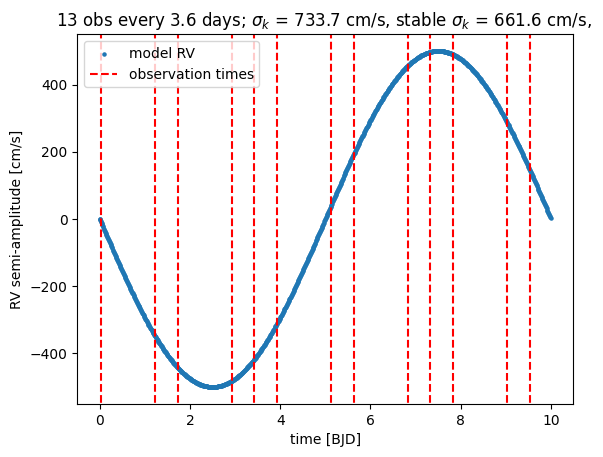

In [7]:
### strategy
cadence = 3.6
n_obs = 13

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/strategy1.pdf', format='pdf')
plt.legend()
plt.show()

/tmp/ipykernel_1597466/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1597466/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 1.53358008e-05  6.50791151e-04 -1.18316516e-03]
 [ 6.50791151e-04  1.42440663e+01  4.85720876e-01]
 [-1.18316516e-03  4.85720876e-01  1.04180397e+00]]
sigma_k using linalg.inv:  268.32755913655416
sigma_k using linalg.solve:  268.32755913655416
sigma_k using 1/sqrt(FIM_ii):  255.35641374407612


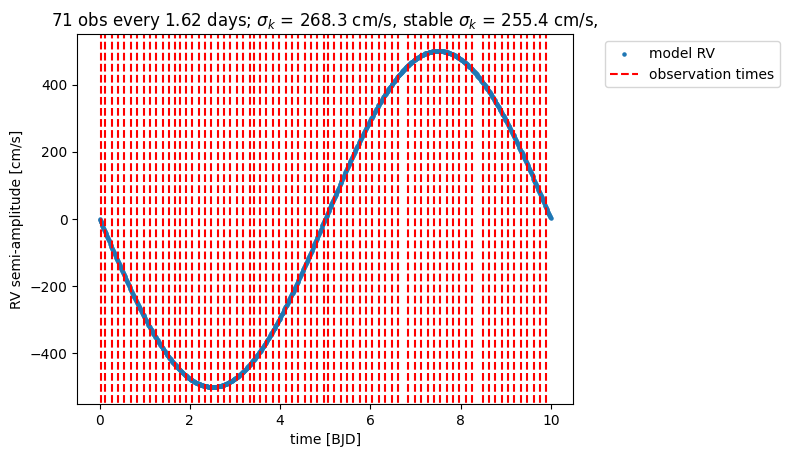

In [7]:
### strategy
cadence = 1.62
n_obs = 71

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/strategy2.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

FIM:  [[ 1.13069796e-05 -3.11163361e-03 -1.69657424e-04]
 [-3.11163361e-03  2.96939303e+01 -1.28795993e+00]
 [-1.69657424e-04 -1.28795993e+00  1.17990399e+00]]
sigma_k using linalg.inv:  302.91411551606774
sigma_k using linalg.solve:  302.91411551606774
sigma_k using 1/sqrt(FIM_ii):  297.39022975459255


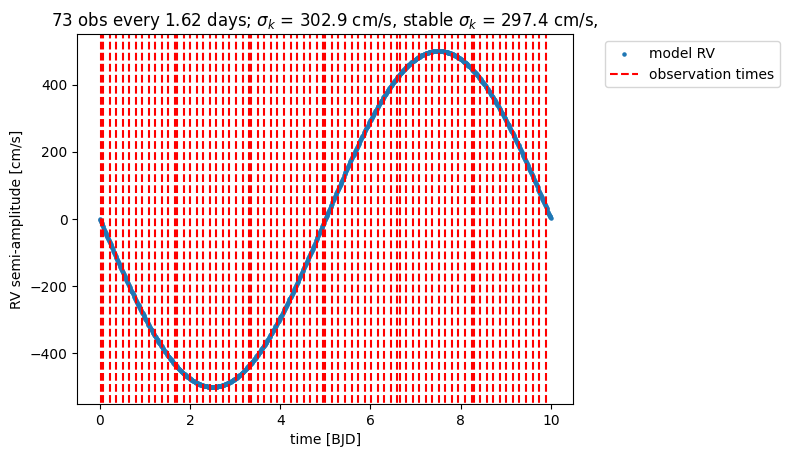

In [8]:
### strategy
cadence = 1.62
n_obs = 73

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/strategy3.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [11]:
dim = 100
n_observations = np.linspace(3, 102, dim).astype(int)
cadence = 3 #4.97 #1.62 

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []
for n_obs in n_observations:
    t = make_t(n_obs, cadence, start)
    sigma = cov_matrix(t, params)
    sigma += 1e-6 
    
    fim = calculate_fim(t, sigma, test_theta)
    fi_k = fim[0][0]
    inv_fim = inv(fim)
    sigma_k = np.sqrt(inv_fim)[0][0]
    sigma_k_stable = np.sqrt(1/fim[0][0])
    inv_fim_solve = solve(fim, np.diag(np.ones(len(test_theta)))) 
    sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
    
    sigma_k_test.append(sigma_k)
    sigma_k_solve_test.append(sigma_k_solve)
    sigma_k_stable_test.append(sigma_k_stable)
    
    fi_k_test.append(fi_k)
    

/tmp/ipykernel_512571/2030000514.py:17: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512571/2030000514.py:20: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


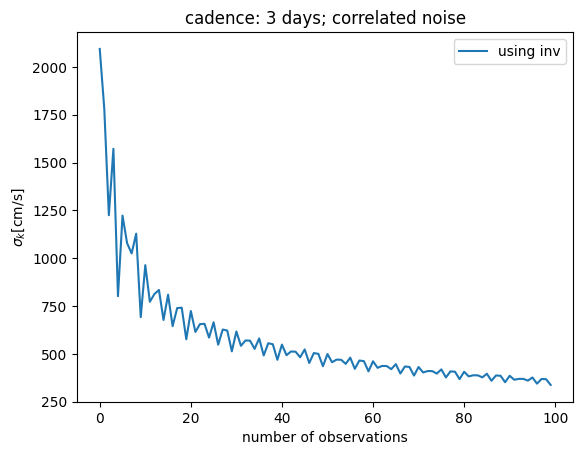

In [10]:
plt.plot(range(len(sigma_k_test)), sigma_k_test, label='using inv')
#plt.plot(range(len(sigma_k_stable_test)), sigma_k_stable_test, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {cadence} days; correlated noise")
plt.legend()
plt.show()

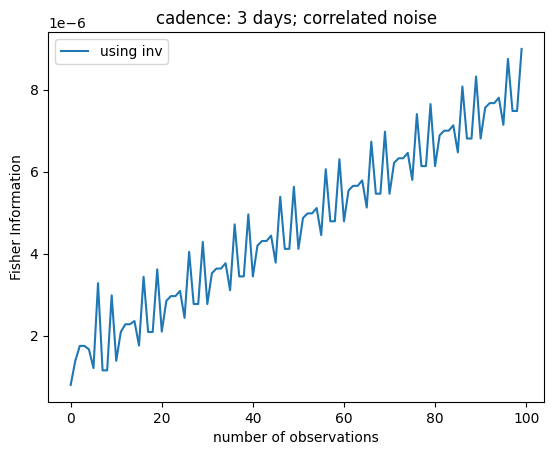

In [12]:
plt.plot(range(len(fi_k_test)), fi_k_test, label='using inv')
#plt.plot(range(len(sigma_k_stable_test)), sigma_k_stable_test, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel("Fisher Information")
plt.title(f"cadence: {cadence} days; correlated noise")
plt.legend()
plt.show()

/tmp/ipykernel_1597466/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1597466/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 6.48702462e-06  1.10440893e-02  5.62680621e-06]
 [ 1.10440893e-02  2.94109896e+02 -9.26121987e+00]
 [ 5.62680621e-06 -9.26121987e+00  7.80884203e-01]]
sigma_k using linalg.inv:  414.61840453638905
sigma_k using linalg.solve:  414.61840453638905
sigma_k using 1/sqrt(FIM_ii):  392.62434687921916


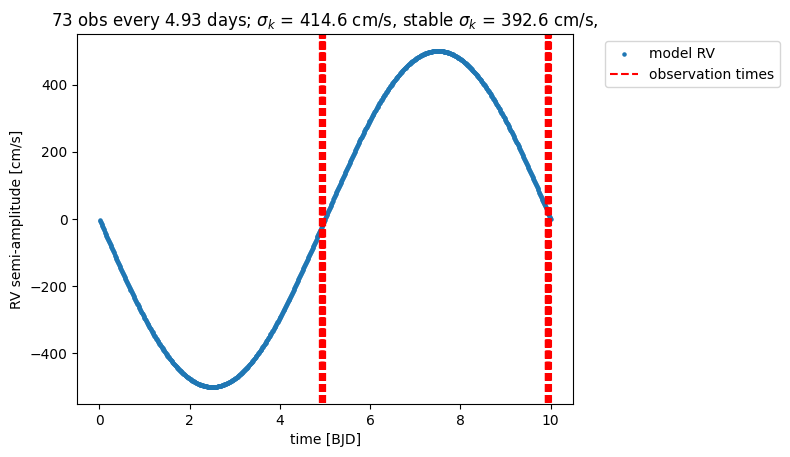

In [26]:
### strategy
cadence = 4.93
n_obs = 73

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Let's try the elbow of the yellow strip in the sensitivity map.

/tmp/ipykernel_1597466/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1597466/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 1.28680405e-06 -3.43446771e-04  5.98237056e-05]
 [-3.43446771e-04  4.49034867e+00  6.86481583e-01]
 [ 5.98237056e-05  6.86481583e-01  1.78738385e-01]]
sigma_k using linalg.inv:  958.0301244847288
sigma_k using linalg.solve:  958.0301244847288
sigma_k using 1/sqrt(FIM_ii):  881.543586581713


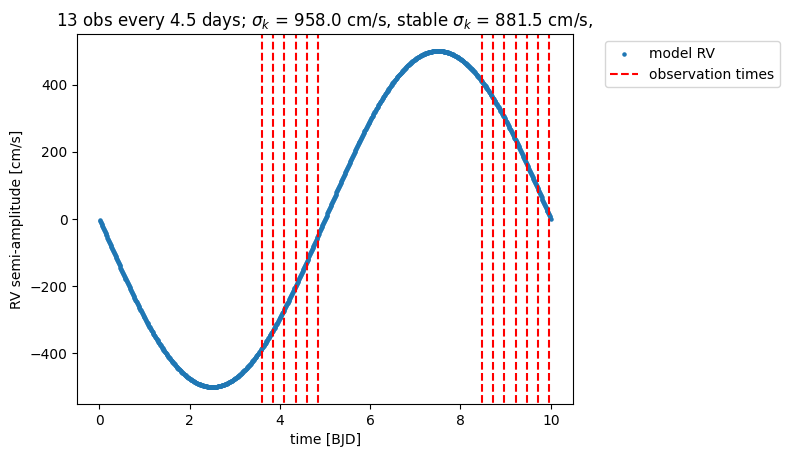

In [9]:
### strategy
cadence = 4.5
n_obs = 13

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

/tmp/ipykernel_1597466/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1597466/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 4.61474681e-07 -1.32365170e-04 -9.89334482e-19]
 [-1.32365170e-04  8.19382751e+00  1.60742827e+00]
 [-1.03098716e-18  1.60742827e+00  3.21485655e-01]]
sigma_k using linalg.inv:  1691.1413412604804
sigma_k using linalg.solve:  1691.1413412604804
sigma_k using 1/sqrt(FIM_ii):  1472.0618600807738


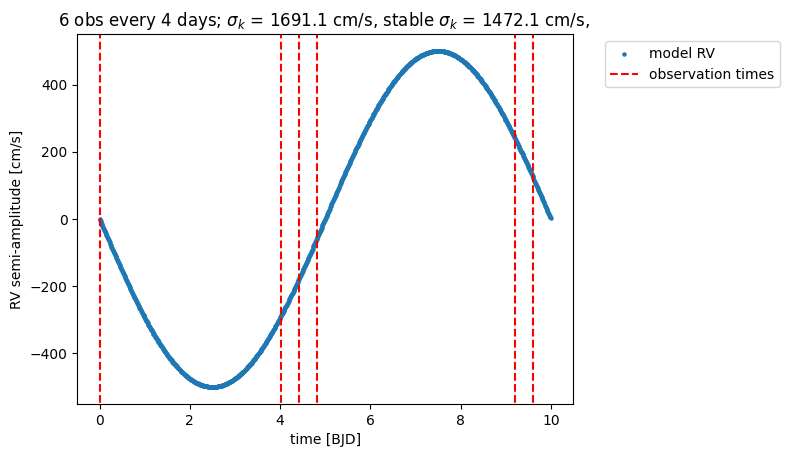

In [10]:
### strategy
cadence = 4
n_obs = 6

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Now what happens if I fix n_obs while cranking up the cadence? The sensitivity map suggests it'll get better, both this way, and if I crank down the cadence. So, let's try both.

/tmp/ipykernel_1597466/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1597466/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 1.52010840e-06 -1.29525186e-03 -2.08618159e-04]
 [-1.29525186e-03  5.11891331e+00  8.73007480e-01]
 [-2.08618159e-04  8.73007480e-01  1.50028685e-01]]
sigma_k using linalg.inv:  971.1926729834508
sigma_k using linalg.solve:  971.1926729834508
sigma_k using 1/sqrt(FIM_ii):  811.078185500621


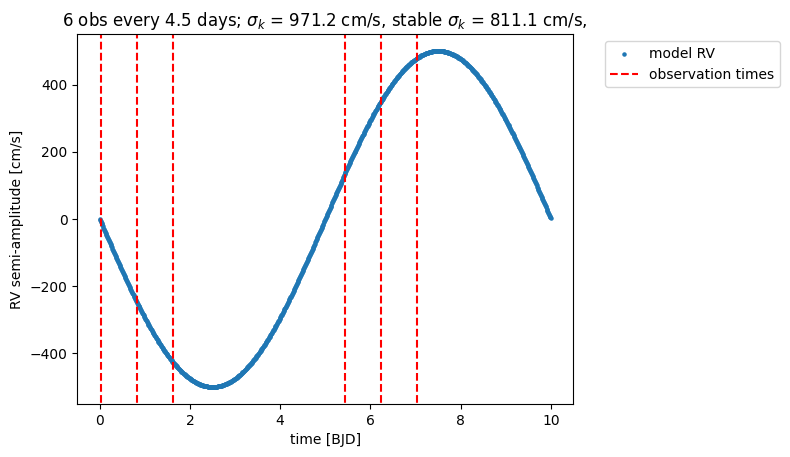

In [11]:
### strategy
cadence = 4.5
n_obs = 6

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

/tmp/ipykernel_1597466/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1597466/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 3.08832922e-06 -4.19775123e-03 -7.48179126e-04]
 [-4.19775123e-03  9.29512041e+00  1.67643232e+00]
 [-7.48179126e-04  1.67643232e+00  3.04805876e-01]]
sigma_k using linalg.inv:  928.4000282315698
sigma_k using linalg.solve:  928.4000282315698
sigma_k using 1/sqrt(FIM_ii):  569.0339848729733


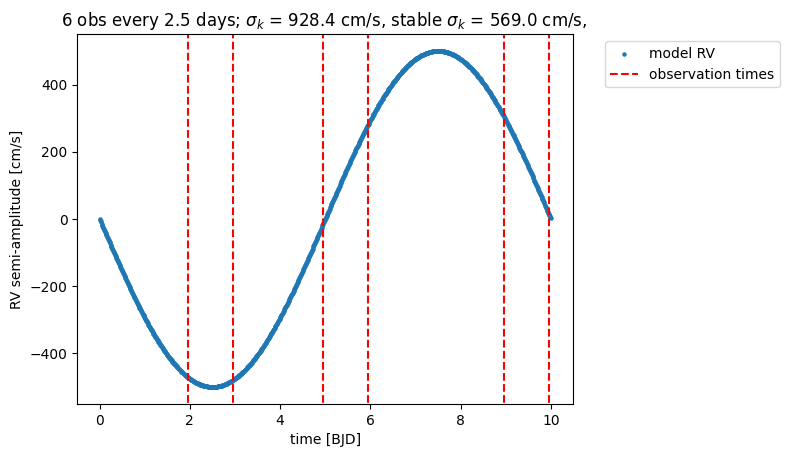

In [12]:
### strategy
cadence = 2.5
n_obs = 6

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Let's try a purple strategy that should be more yellow because it is at 5-day cadence.

/tmp/ipykernel_1597466/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1597466/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 3.95324327e-06 -1.62179786e-02  1.16330262e-03]
 [-1.62179786e-02  7.49833360e+01 -3.26057864e+00]
 [ 1.16330262e-03 -3.26057864e+00  7.51097500e-01]]
sigma_k using linalg.inv:  3144.8532225200174
sigma_k using linalg.solve:  3144.8532225200174
sigma_k using 1/sqrt(FIM_ii):  502.9481669571505


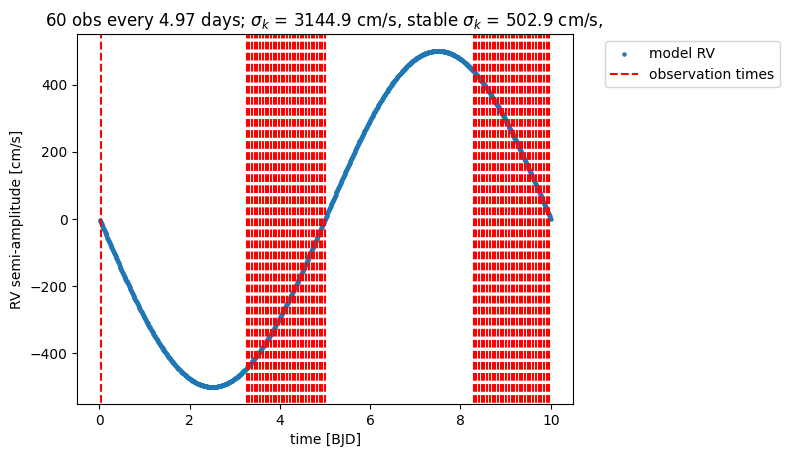

In [18]:
### strategy
cadence = 4.97 #1.62 
n_obs = 60 #71

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat = np.arange(start, end, cadence) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Why does adding more observations tighten the sampling in phase-folded space? Especially since the period is 10 days, shouldn't changing n_obs by 10 (which is what I did in the screenshots I sent Lily and Megan) affect nothing? Oh no...is it because I feed in the phase folded test_t timeseries, and model() needs un-phase-folded time? That's probably it.

In [26]:
strat[25]-strat[24]

4.9699999999998

/tmp/ipykernel_1449259/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1449259/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


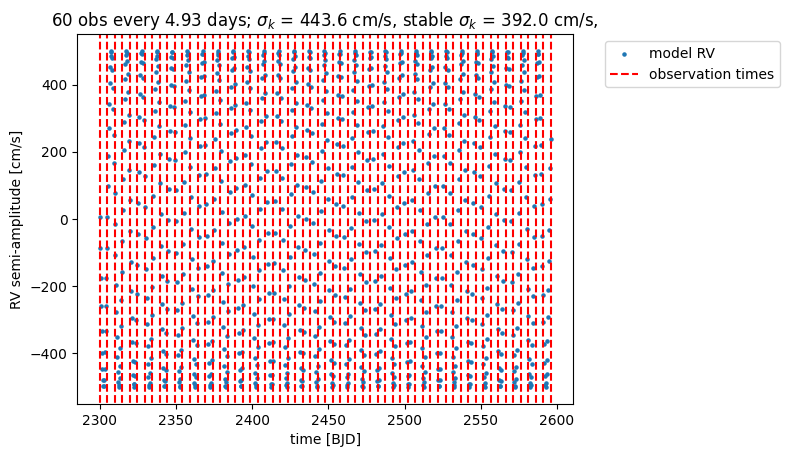

In [27]:
### strategy
cadence = 4.93
n_obs = 60
sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta)

### plot observations from strategy
end = start + cadence * n_obs
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
y = model(test_t, test_theta)
y_phase_folded = model_phase_folded(test_t_phase_folded, test_theta)
#strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat = np.arange(start, end, cadence) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

### non phase folded
plt.scatter(test_t, y, s=5, label='model RV')
plt.axvline(2300, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat:
    plt.axvline(i, min(y), max(y), linestyle='--', c='r')

### phase folded
"""
#plt.scatter(test_t % test_P, y, s=5, label='model RV')
plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
"""

plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#### Let's explore the full parameter space of (n_obs, cadence), so that we can plot sensitivity maps

In [28]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)
sigma_ks = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

#with tqdm.tqdm(total=100) as pbar:
for enum_i, i in enumerate(n_observations):
    for enum_j, j in enumerate(cadences):
        try:
            sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=i, cadence=j, theta=test_theta)
        except Exception as e:
            print(e, i, j)
            sigma_k, sigma_k_stable, sigma_k_solve = np.nan, np.nan, np.nan
            
        sigma_ks[enum_i][enum_j] = sigma_k
        sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
        sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

/tmp/ipykernel_1449259/3276298021.py:133: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1449259/3276298021.py:136: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


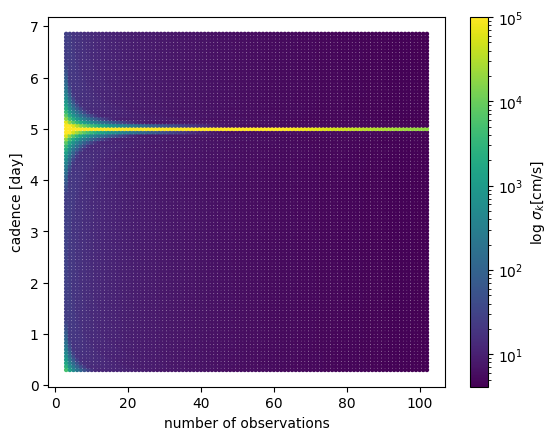

In [82]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e5)) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"log $\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.savefig("plots/n_obs-cadence-sigma_k-correlated.pdf", format="pdf")
plt.show()

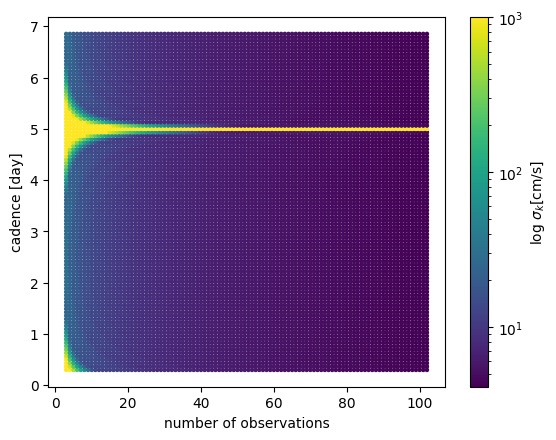

In [47]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e3))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"log $\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.savefig("plots/n_obs-cadence-sigma_k-solve-correlated.pdf", format="pdf")
plt.show()

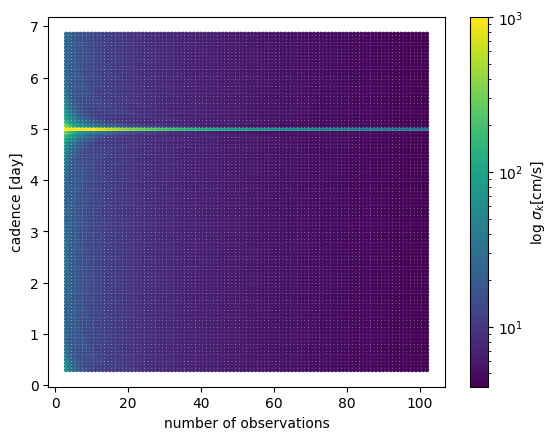

In [48]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e3))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"log $\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.savefig("plots/n_obs-cadence-sigma_k-stable-correlated.pdf", format="pdf")
plt.show()

Let's marginalize over different starts time to get a more smoothed picture

In [35]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)

#with tqdm.tqdm(total=100) as pbar:
starts = np.linspace(2300, 2300+test_P, 200)
sigma_ks_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve_all = np.ones(dim**2).reshape((dim,dim))
    
for start in starts: 
    sigma_ks = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

    for enum_i, i in enumerate(n_observations):
        for enum_j, j in enumerate(cadences):
            try:
                sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)
            except Exception as e:
                print(e, ", culprit: ", start, i, j)

            sigma_ks[enum_i][enum_j] = sigma_k
            sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
            sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

            sigma_ks_all += sigma_ks
            sigma_ks_stable_all += sigma_ks_stable
            sigma_ks_solve_all += sigma_ks_solve

/tmp/ipykernel_1449259/3276298021.py:114: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1449259/3276298021.py:122: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


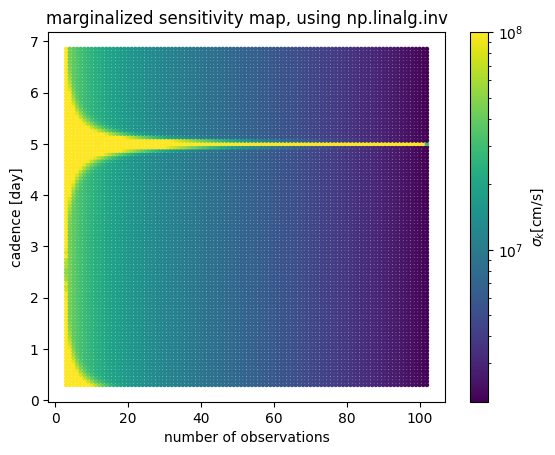

In [51]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_all.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e8))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using np.linalg.inv")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()

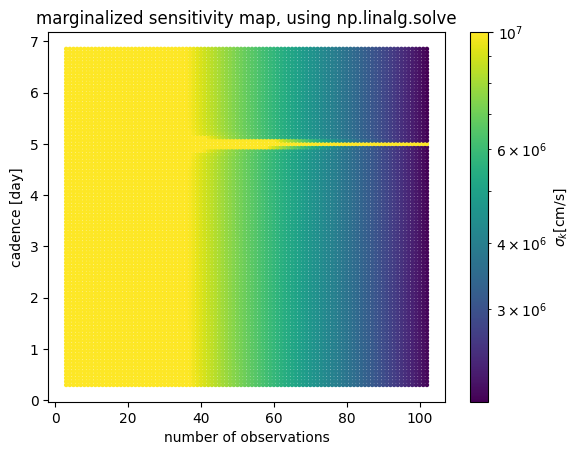

In [42]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve_all.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e7))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using np.linalg.solve")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()

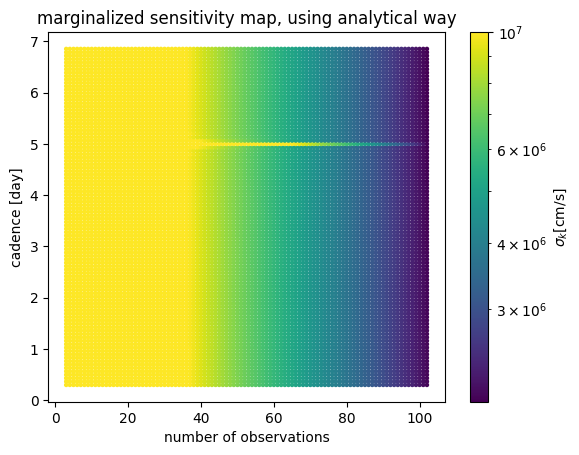

In [45]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable_all.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e7))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using analytical way")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()